# Notebook for the preprocessing of the audio files

The preprocessing consists of the following steps:
1. Read in files
2. Resample files to standardized sampling rate (e.g. 32000kHz)
3. Create clips of equal length
    - Select minimum length for all clips (e.g. 20 seconds)
    - Divide longer audios into clips
        - Drop last clip of audio if significantly shorther than mininum length
    - Extend shorter audios to minimum length (add silence at end)
    - give new index (keep original index too, somehow)
4. Compute mel spectrogram for each clip and save it (to dataframe?)
5. Rescale (MinMax Scaler / Standard scaler?)

Due to the large amounts of data this needs to be done using a generator

## Additional steps for the kNN

- Apply Lomb-Scargle / FFT
- Extract meaningful audio features
- Save information to df

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
from tqdm import tqdm
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset' # subdirectory name of dataset

In [2]:
#!pip install tensorflow keras

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-06-09 13:25:03.874198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 13:25:03.874460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 13:25:04.144691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 13:25:04.554750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 13:25:06.420995: W tensorflow/compiler/tf2

Num GPUs Available:  1


2024-06-09 13:25:08.677227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 13:25:09.058881: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 13:25:09.059471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Read filelist dataframe

In [4]:
df = pd.read_csv(XC_ROOTDIR + 'dataset_test_download.csv', index_col = 0)

df.head()

gen      sp     ssp  group                en  \
id                                                        
465832  Turdus  merula     NaN  birds  Common Blackbird   
624232  Turdus  merula     NaN  birds  Common Blackbird   
735377  Turdus  merula  merula  birds  Common Blackbird   
474372  Turdus  merula     NaN  birds  Common Blackbird   
530694  Turdus  merula     NaN  birds  Common Blackbird   

                           rec       cnt  \
id                                         
465832  Beatrix Saadi-Varchmin   Germany   
624232        Ireneusz Oleksik    Poland   
735377         Frank Holzapfel   Germany   
474372         Elias A. Ryberg    Norway   
530694        Nelson Conceição  Portugal   

                                                      loc      lat      lng  \
id                                                                            
465832   Bad Endorf (near Rosenheim)), Oberbayern, Bayern  47.9075  12.2896   
624232        ROD Browarnik (near  Tychy), Tychy, śląskie  50.1329  18.9570   
735377                  Hochdorf / Enz, Baden-Württemberg  48.8867   8.9957   
474372                                    Stange, Hedmark  60.7225  11.1095   
530694  Santa Maria, Mato Santo Espírito(near  Tavira)...  37.1379  -7.6303   

        ... playback-used temp regnr auto  dvc  mic    smp length_seconds  \
id      ...                                                                 
465832  ...            no  NaN   NaN   no  NaN  NaN  44100            299   
624232  ...            no  NaN   NaN   no  NaN  NaN  48000            297   
735377  ...            no  NaN   NaN   no  NaN  NaN  48000            295   
474372  ...            no  NaN   NaN   no  NaN  NaN  48000            291   
530694  ...            no  NaN   NaN   no  NaN  NaN  48000            290   

       nr other                                       fullfilename  
id                                                                  
465832        1  ../../data/test_dataset/Turdus merula_Common B...  
624232        1  ../../data/test_dataset/Turdus merula_Common B...  
735377        0  ../../data/test_dataset/Turdus merula_Common B...  
474372        2  ../../data/test_dataset/Turdus merula_Common B...  
530694        0  ../../data/test_dataset/Turdus merula_Common B...  

[5 rows x 40 columns]

## For testing purposes only use 10 sepcies

In [5]:
len(df)

1350

In [6]:
species = np.unique(df["en"])
species[:10]
df = df[df["en"].apply(lambda x: x in species[:10])]
len(df)

300

## Preprocessing for example audio file

In [7]:
files = df["fullfilename"].to_list()
file = files[10]
sample_rate = 32000

audio, sr = librosa.load(file, sr = sample_rate)

### Play audio

In [60]:
audio = audio[:20*sr] # only first 20 seconds
len(audio)

640000

In [9]:
Audio(data = audio, rate = sr)

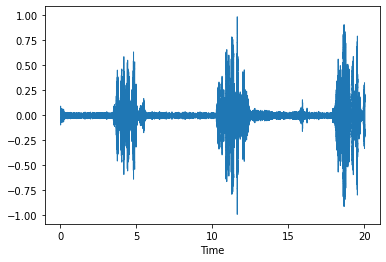

In [45]:
librosa.display.waveshow(audio, sr = sr)

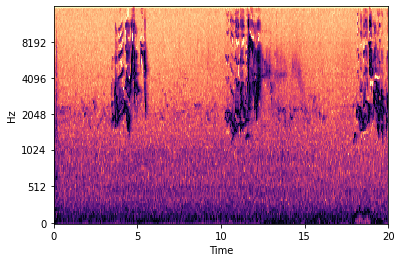

In [54]:
n_fft = 2048 #4096
hop_length = 512
n_mels = 128

mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=16000)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

librosa.display.specshow(np.abs(log_mel_spectrogram), sr = sr, x_axis = "time", y_axis = "mel")

In [52]:
20*sr/hop_length

1250.0

In [53]:
log_mel_spectrogram.shape

(128, 1251)

In [12]:
def to_log_mel_spec(file, sr, n_fft = 2048, hop_length = 512, n_mels = 128, fmax = sr/2):
    audio, sr = librosa.load(file, sr = sr)
    audio = audio[:20*sr] # only first 20 seconds
    
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    return log_mel_spectrogram

In [56]:
file_nr = [0, 30, 60, 90, 120, 150]
specs = []
for nr in file_nr:
    specs.append(to_log_mel_spec(files[nr], sr = 32000, fmax = 20000))

In [57]:
labels = []

for i in file_nr:
    labels.append(list(df[i:i+1].en))
labels

[['Common Blackbird'],
 ['Common Chaffinch'],
 ['Barn Swallow'],
 ['Common Chiffchaff'],
 ['Black Redstart'],
 ['Common Nightingale']]

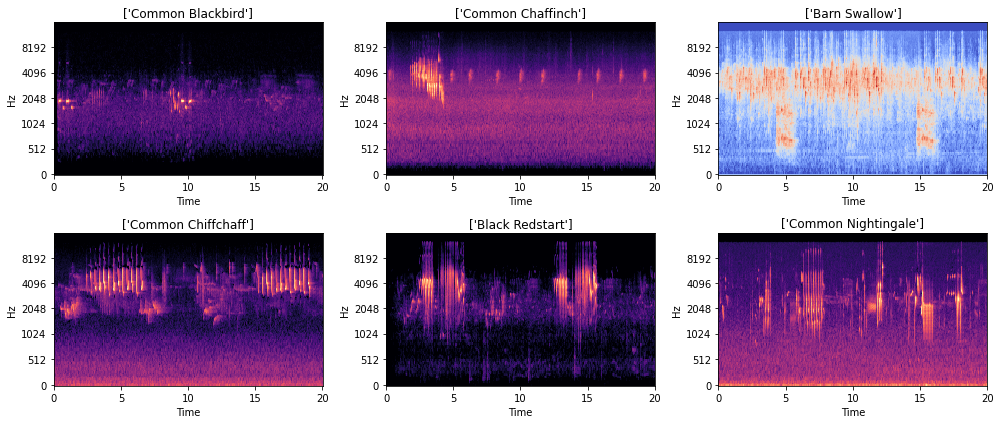

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize = (14, 6))

for i in range(len(file_nr)):
    ax[i//3, i%3].set_title(labels[i])
    librosa.display.specshow(specs[i], sr = sr, x_axis = "time", y_axis = "mel", ax = ax[i//3, i%3])
    plt.tight_layout()

In [21]:
specs = []
for nr in file_nr:
    specs.append(to_log_mel_spec(files[nr], sr = 24000, fmax = 20000, n_mels = 64))

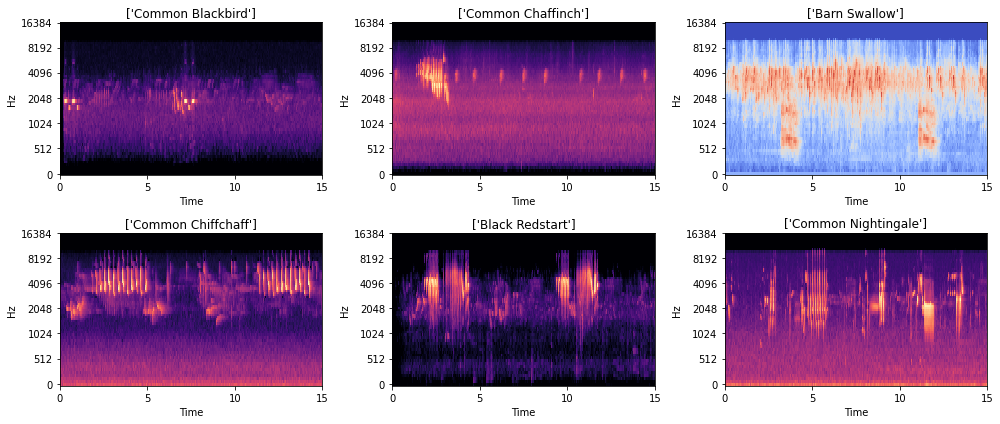

In [22]:
fig, ax = plt.subplots(2, 3, figsize = (14, 6))

for i in range(len(file_nr)):
    ax[i//3, i%3].set_title(labels[i])
    librosa.display.specshow(specs[i], sr = sr, x_axis = "time", y_axis = "mel", ax = ax[i//3, i%3])
    plt.tight_layout()

In [ ]:
import keras

length_clip = 20 #s
n_mels = 128

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_files, labels, batch_size=16, dim=(), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

### Divide into clips

In [18]:
clip_length = 20 # seconds
clip_tolerance = .8 # minimum length for last clip
samples_per_clip = clip_length*sample_rate

clips = []

for start in range(0, len(audio), samples_per_clip):
    end = start + samples_per_clip
    clip = audio[start:end]
            
    if len(clip) < samples_per_clip and (len(clip) > clip_tolerance*samples_per_clip or start == 0):
        clip = np.pad(clip, (0, samples_per_clip - len(clip)), 'constant')
            
    clips.append(clip)

In [19]:
Audio(data = clips[-1], rate = sample_rate)

In [20]:
np.array(clips).shape

(1, 640000)